# Финальный проект ds_13_industry_2

### Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## 1. Исследовательский анализ данных

### 1.1 Импорт библиотек

In [1]:
!pip install pandas==1.1.3

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import re

### 1.2 Чтение данных

In [3]:
#локальное чтение данных
data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')

### 1.3 Изучение и анализ данных

Для удобства, напишем функцию, выводящую общую и статистическую информацию о датафрейме и, также, первые 10 строк таблицы:

In [4]:
def eda(data):
    data.info()
    display(data.describe())
    display(data.head(10))
    print('Количество полных дубликатов', data.duplicated().sum())

#### 1.3.1 Данные об электродах

In [5]:
eda(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Количество полных дубликатов 0


In [6]:
data_arc['key'].nunique()

3214

Выведем график распределения и диаграмму размаха Активной мощности.<br>
Для удобства, напишем функцию, которой будем пользоваться в дальнейшем:

In [7]:
def dist_box(data, column):
    plt.figure(figsize=(15, 6))
    sns.distplot(data[column].dropna()).set_title("График распределения '" + column +"'")
    plt.show()
    plt.figure(figsize=(15, 6))
    sns.boxplot(data[column].dropna()).set_title("Диаграмма размаха '" + column +"'")
    plt.show()

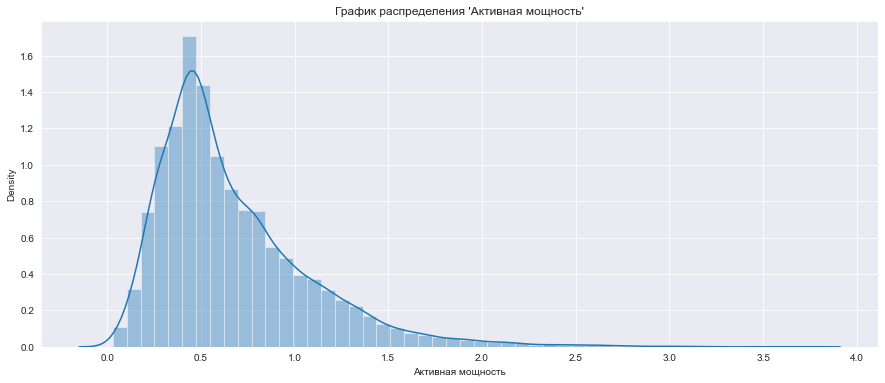

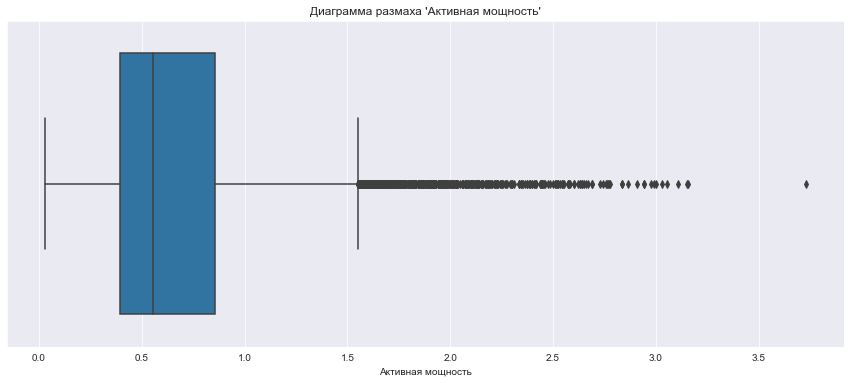

In [8]:
dist_box(data_arc, 'Активная мощность')

Можем наблюдать нормальное распределение со сдвигом влево, присутствует одно аномальное значение, равное **3.7**, но оно не столь критично.

Изучим графики реактивной мощности:

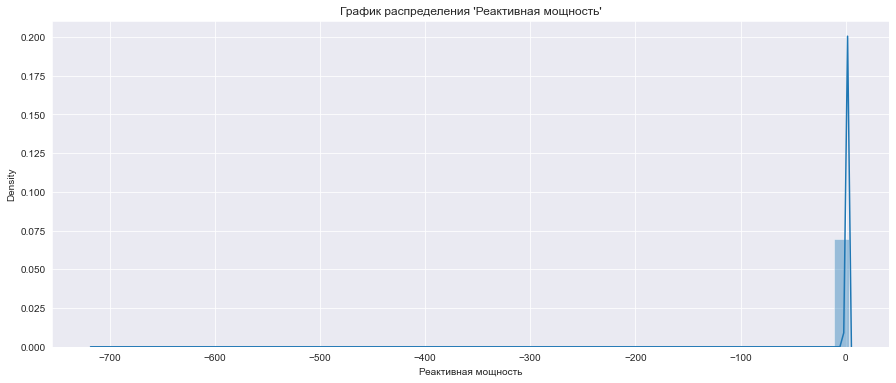

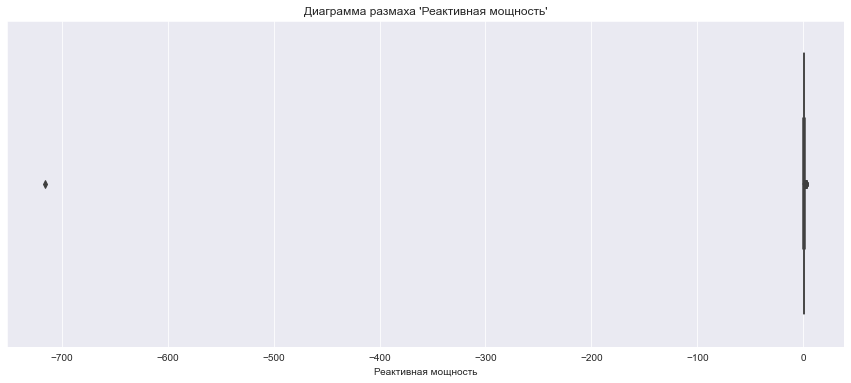

In [9]:
dist_box(data_arc, 'Реактивная мощность')

Как мы можем наблюдать, аномальное отрицательное значение реактивной мощности не позволяет сделать никаких выводов и от него следует избавиться ещё до этапа предобработки данных:

In [10]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

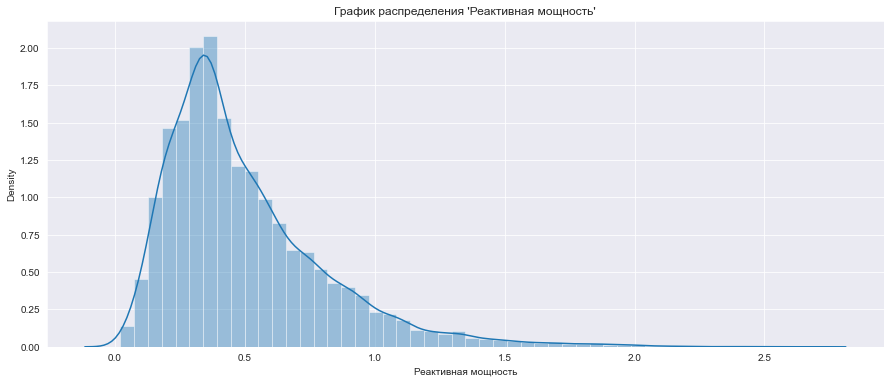

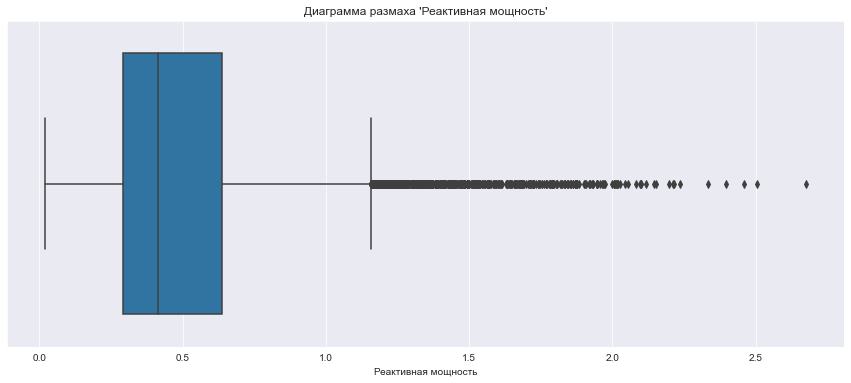

In [11]:
dist_box(data_arc, 'Реактивная мощность')

Можем заметить, что графики этих двух параметров выглядят достаточно схожим образом.<br>
Изучим индекс корреляции между ними:

In [12]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9631819131519801

Ярко выраженная положительная корреляция между двумя этими параметрами.<br>
Вполне возможно, что следует избавиться от одного из них, либо на основе двух этих параметров вывести ещё один, чтобы избежать переобучаемости модели.

**Вывод:**

- Датасет содержит **14876** строк и **5** столбцов.
- Полные дубликаты отсутствуют.
- Можно заметить, что количество уникальных значений столбца ``key`` намного меньше общего количества строк в датасете - как и было объявлено в описании данных, в партиях наблюдается различное количество итераций обработки.
- Можно наблюдать аномальное минимальное значение реактивной мощности, равное **-715.5**, что может быть обусловлено ошибкой выгрузки, либо ошибкой работы датчиков.
- Тип данных столбцов ``Начало нагрева дугой`` и ``Конец нагрева дугой`` требуется изменить на тип **datetime64**, т.к. главная задача проекта - оптимизация потребления электроэнергии и, в дальнейшем, потребуется рассчитать время тепловой обработки.
- Замечена ярко выраженная корреляция между активной и реактивной мощностями (Индекс корреляции **0.96**).

#### 1.3.2 Данные о подаче сыпучих материалов (объём)

Выведем общую и статистическую информацию по данной таблице:

In [13]:
eda(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Количество полных дубликатов 0


Проверим номера партий на уникальность, т.к. в предыдущей таблицы наблюдения были разбиты по итерациями, соответствующим определённой партии:

In [14]:
data_bulk['key'].nunique()

3129

Уникальное количество значений столбца ``key`` - **3129** и оно равно общему количеству наблюдений в данной таблице.<br>
Можно сделать вывод, что каждое наблюдение - отдельная партия.

**Вывод:**

- Датасет содержит **3129** наблюдений по партиям, что чуть меньше, чем аналогичное значение в таблице ``data_arc`` (**3214**).
- Дубликаты отсутствуют.
- Можно заметить больше количество пропущенных значений, которое обусловлено тем, что в каждой партии используется определённое сочетание сыпучих материалов (в таблице, по всей видимости, присутствуют наблюдения по всем возможным сыпучим материалам) и некоторые из них попросту не применяются в некоторых партиях.
- Каждое наблюдение в таблице соотстветствует одной и только одной определённой партии, что позволит, в дальнейшем, объединить наши таблицы по столбцу ``key``.

#### 1.3.3 Данные о подаче сыпучих материалов (время)

Выведем общую и статистическую информацию по данной таблице:

In [15]:
eda(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Количество полных дубликатов 0


**Вывод:**

- Можем наблюдать таблицу, аналогичную предыдущей, но вместо данных об объёме сыпучих материалов указано время их подачи.
- Как и в предыдущей таблице, присутствует значительное количество пропущенных значений.
- Данную таблицу достаточно затруднительно использовать для обучения модели, т.к. она содержит лишь время подачи, без учёта итерации, на которой это происходит. Стоит решить, в дальнейшем, стоит ли её использовать.

#### 1.3.4 Данные о продувке сплава газом

Выведем общую и статистическую информацию по данной таблице и, также, график распределения и диаграмму размаха:

In [16]:
eda(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Количество полных дубликатов 0


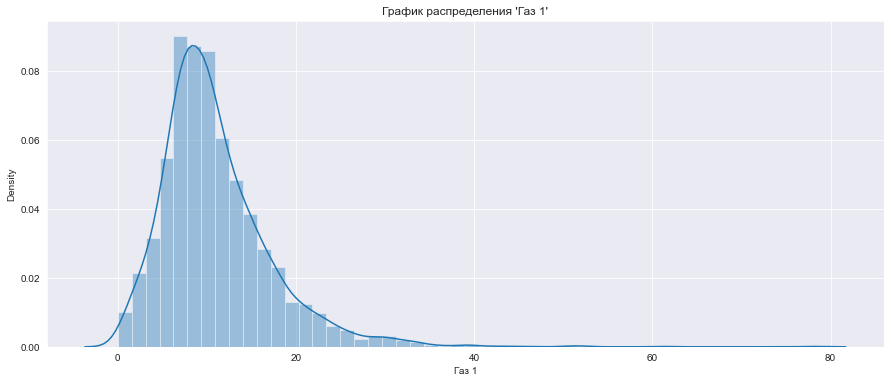

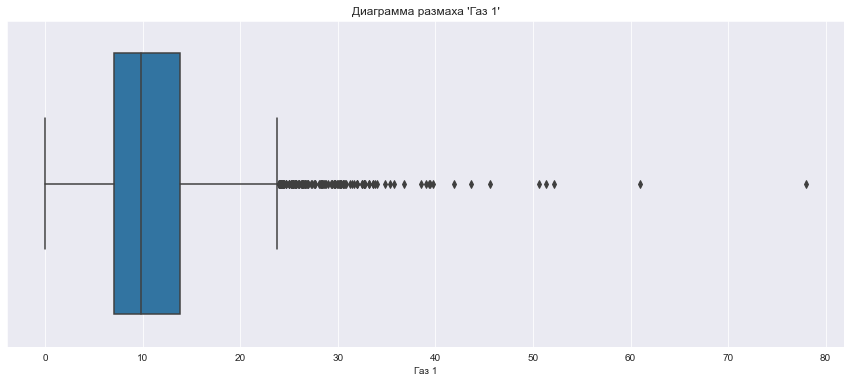

In [17]:
dist_box(data_gas, 'Газ 1')

Проверим, соответствует ли каждое наблюдение определённому номеру партии и только ему:

In [18]:
data_gas['key'].nunique()

3239

**Вывод:**
- Каждое наблюдение соответствует определённому номеру партии.
- Присутствуют значения, которые отличаются от средних большую сторону, но не позволяют сделать какие-либо выводы, т.к. не выглядят аномальными - распределение выглядит нормальным.
- Полные дупликаты и пропуски отстутствуют.

#### 1.3.5 Результаты измерения температуры

Выведем общую и статистическую информацию по данной таблице и, также, первые десять её строк:

In [19]:
eda(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Количество полных дубликатов 0


Как мы можем наблюдать, в данной таблице наблюдения разбиты на отдельные итерации, как и в таблице данных об электродах.<br>
Присутствуют пропущенные значение по температуре, изучим их:

In [20]:
data_temp.iloc[data_temp[(data_temp.isnull().sum(axis=1) >=1)].index]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


По всей видимости, данные о температуре отстутствуют, начиная с **2500** партии.

Выведем график распределения и диаграмму размаха:

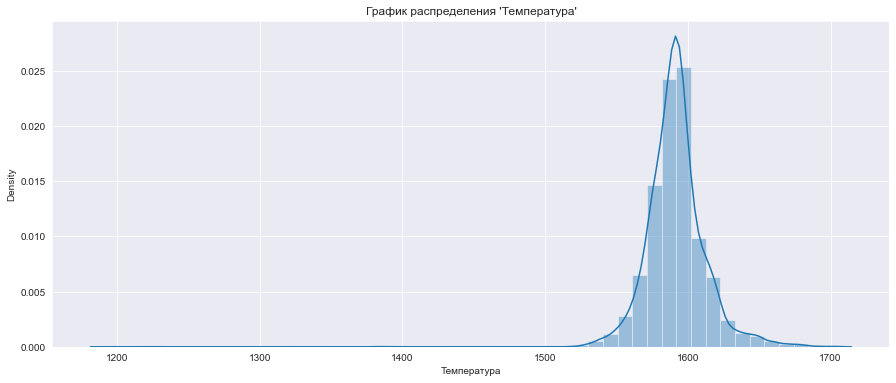

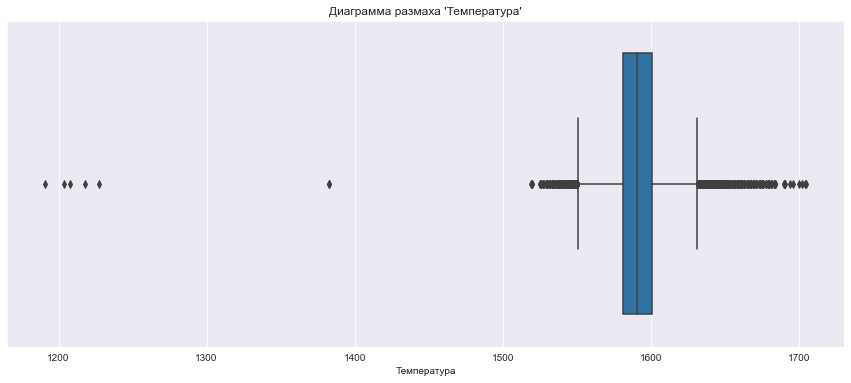

In [21]:
dist_box(data_temp, 'Температура')

**Вывод:**
- Присутствуют некоторые аномальные выбросы но, в целом, распределение выглядит нормальным.
- Начиная с 2500 партии данные о температуре отстутствуют - т.к. это достаточно важный параметр для нас, следует в дальнейшем это учитывать и для дальнейшего обучения модели отобрать только те партии, в которых присутствует замер температуры.
- В данной таблице отображены замеры температуры по всем доступным итерациям обработки в партии и вполне логичным является добавить в данные для обучения измеренную температуру первой и последней итерации, либо разницу температур между первой и последней итерацией.
- Полные дубликаты отстутствуют.

#### 1.3.5 Данные о проволочных материалах (объём)

Выведем общую и статистическую информацию по данной таблице:

In [22]:
eda(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество полных дубликатов 0


**Выводы:**
- Можно наблюдать, что проволочный материал под номером 1 используется в большинстве случаев, но это не позволяет сделать никаких вразумительных выводов.
- Присутствует большое количество пропущенных значений, но это обусловлено тем, что в каждой партии/итерации используется определённое сочетание проволочных материалов.
- Дубликаты отсутствуют.

#### 1.3.5 Данные о проволочных материалах (время)

Выведем общую и статистическую информацию по данной таблице:

In [23]:
eda(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество полных дубликатов 0


**Выводы:**
- Данная таблица идентична предыдущей, но вместо объёма содержит информацию о времени введения провлочных материалов.
- Этими данными, скорее всего, можно будет пренебречь и в данных для обучения будет достаточно лишь информации об объёме проволочных материалов.

**Общий вывод по шагу:**

- Данные были загружены и изучены
- По каждой из таблиц были выведены общие и статистические данные
- Проведена проверка данных на наличие пропусков и дубликатов: некоторые таблицы содержат пропуски, но это обусловлено самой природой данных - в некоторых случаях они возникли из-за того, что определённая добавка в данной итерации/партии не используется
- В таблице **data_temp** отсутствует некоторая часть данных, что не позволит использовать всю имеющуюся информацию для дальнейшего обучения модели
- в таблице **data_arc** присутствует ярко выраженная положительная корреляция между активной и реактивной мощности и, чтобы избежать негативного влияния при обучении модели, требуется вывести новый признак на основе этих двух (к примеру, рассчитать полную мощность)

## План работы

- Провести предобработку данных: изменить тип данных в тех таблицах, в которых это требуется
- Обработать пропущенные значения
- Объединить таблицы в одну, которая будет содержать следующие признаки: количество итераций, первая и последняя температура, рассчитанная полная мощность, объём сыпучих и проволочных материалов, данные о продувке сплава газом.
- Последнее измерение температуры будет являться целевым признаком.
- Провести обучение нескольких моделей, подобрать оптимальные гиперпараметры и отобрать из моделей ту, которая покажет наилучшие результаты.

## 2. Предобработка данных

План на данный этап работы:
- Рассчитаем и добавим новый признак в таблицу **data_arc** - ``Полная мощность``.
- Сгруппируем данную таблицу по партиям, оставив в ней только признак со значениями полной мощности и количества итераций обработки.
- Таблицу **data_temp** сгруппируем по столбцу **key** и добавим два новых признака со значениями первой и последней измерянной температурой. Требуется учесть, что начиная с 2500 партии у нас присутствует только первое измерение температуры и от данных партий следует избавиться, т.к. последняя температура является целевым признаком.
- Объединим таблицы **data_arc**, **data_bulk**, **data_gas**, **data_temp**, **data_wire** в одну по столбцу ``key``.
- Обработаем пропуски в итоговой таблице.
- Разделим выборки на тестовую и обучающую, произведём масштабирование количественных признаков.

### 2.1 Рассчёт признака "Полная мощность"

Ранее мы выясняли, что в наших данных активная и реактивная мощности достаточно сильно коррелируют между собой, что может негативно сказаться на работе моделей и, целесообразно было бы вывести на основе этих двух признаков один новый.

Зная активную ($P$) и реактивную мощность ($Q$), полную мощность ($S$) возможно рассчитать по следующей формуле:
$$
S = \sqrt{P^2 + Q^2}
$$

Добавим данную величину в таблицу **data_arc**:

In [24]:
def full_power(row):
    return (row['Активная мощность']**2 + row['Реактивная мощность']**2)**.5

In [25]:
data_arc['full_power'] = data_arc.apply(full_power, axis=1)
display(data_arc.head(10))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527


Признак добавлен.

Подготовим данную таблицу для дальнейшей работы: сгруппируем данные по значению столбца ``key`` и добавим признак с количеством итерации в конкретной партии:

In [26]:
data_arc['n_iterations'] = 1
data_arc_grouped = data_arc[['key', 'full_power', 'n_iterations']].groupby(by='key', as_index = False).sum()
display(data_arc_grouped.head(10))

,key,full_power,n_iterations
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4
5,6,4.786837,4
6,7,2.987777,4
7,8,4.627389,4
8,9,2.555348,5
9,10,3.851739,6


In [27]:
display(data_arc_grouped.head(10))
display(data_arc_grouped.info())

,key,full_power,n_iterations
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4
5,6,4.786837,4
6,7,2.987777,4
7,8,4.627389,4
8,9,2.555348,5
9,10,3.851739,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3214 non-null   int64  
 1   full_power    3214 non-null   float64
 2   n_iterations  3214 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 100.4 KB


None

**Вывод:**
Необходимые признаки добавлены, данные сгруппированы.

### 2.2. Обработка данных о температуре

Выведем таблицу **data_temp** на экран:

In [28]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


С помощью группировки по признаку ``key`` создадим два новых признака - первая и последняя измерянная температура:

In [29]:
data_temp_grouped = data_temp.groupby(by = "key", as_index = False).agg(first_temp= ('Температура', lambda x: list(x)[0]),
                                  last_temp=('Температура', lambda x: list(x)[-1]))

Проверим:

In [30]:
display(data_temp_grouped.head(10))
data_temp_grouped.info()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3216 non-null   int64  
 1   first_temp  3216 non-null   float64
 2   last_temp   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


Избавимся от строк, в которых присутствуют пропуски:

In [31]:
data_temp_grouped = data_temp_grouped.dropna()
#проверим:
data_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2477 non-null   int64  
 1   first_temp  2477 non-null   float64
 2   last_temp   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


**Вывод:**
Таблица готова для дальнейшей работы.

### 2.3. Объединение данных из разных таблиц в одну

Объединим таблицы:

In [32]:
full = (data_temp_grouped.merge(data_arc_grouped, how = 'left', on = 'key')
                 .merge(data_wire, how = 'left', on = 'key')
                 .merge(data_bulk, how = 'left', on = 'key')
                 .merge(data_gas, how = 'left', on = 'key')
        )

In [33]:
display(full.sample(5))
full.info()

,key,first_temp,last_temp,full_power,n_iterations,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
1543,1558,1603.0,1587.0,2.339264,4.0,178.120804,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,87.0,NaN,185.0,NaN,140.0,127.0,6.264700
1681,1696,1535.0,1584.0,5.534332,4.0,90.136803,10.133759,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,138.0,204.0,17.761971
128,131,1568.0,1593.0,6.337441,8.0,48.048000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,211.0,103.0,NaN,312.0,202.0,21.499284
110,113,1645.0,1647.0,4.466633,4.0,7.556640,NaN,96.047951,24.148801,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.377930
1269,1282,1574.0,1594.0,3.255515,3.0,144.284409,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,101.0,105.0,8.369462


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2477 non-null   int64  
 1   first_temp    2477 non-null   float64
 2   last_temp     2477 non-null   float64
 3   full_power    2475 non-null   float64
 4   n_iterations  2475 non-null   float64
 5   Wire 1        2349 non-null   float64
 6   Wire 2        833 non-null    float64
 7   Wire 3        39 non-null     float64
 8   Wire 4        12 non-null     float64
 9   Wire 5        0 non-null      float64
 10  Wire 6        45 non-null     float64
 11  Wire 7        4 non-null      float64
 12  Wire 8        13 non-null     float64
 13  Wire 9        28 non-null     float64
 14  Bulk 1        199 non-null    float64
 15  Bulk 2        13 non-null     float64
 16  Bulk 3        965 non-null    float64
 17  Bulk 4        814 non-null    float64
 18  Bulk 5        53 non-null   

Тип данных корректный.<br>
Избавимся от столбца ``key``, т.к. более он не понадобится:

In [34]:
full = full.drop(['key'], axis = 1)

Обработаем оставшиеся пропуски - присутствуют 2 пропущенных значения в столбцах ``full_power`` и  ``n_iterations``:

In [35]:
full = full.dropna(subset=['full_power', 'n_iterations'])

Оставшиеся пропущенные значениями заполним нулями:

In [36]:
full = full.fillna(0)
#проверим:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   first_temp    2475 non-null   float64
 1   last_temp     2475 non-null   float64
 2   full_power    2475 non-null   float64
 3   n_iterations  2475 non-null   float64
 4   Wire 1        2475 non-null   float64
 5   Wire 2        2475 non-null   float64
 6   Wire 3        2475 non-null   float64
 7   Wire 4        2475 non-null   float64
 8   Wire 5        2475 non-null   float64
 9   Wire 6        2475 non-null   float64
 10  Wire 7        2475 non-null   float64
 11  Wire 8        2475 non-null   float64
 12  Wire 9        2475 non-null   float64
 13  Bulk 1        2475 non-null   float64
 14  Bulk 2        2475 non-null   float64
 15  Bulk 3        2475 non-null   float64
 16  Bulk 4        2475 non-null   float64
 17  Bulk 5        2475 non-null   float64
 18  Bulk 6        2475 non-null 

От пропусков избавились.<br>
Заменим тип данных признака ``n_iterations`` на int, т.к. он более подходящий - количество итераций может быть только целым числом и, также, изменим название признаков для корректной работы моделей:

In [37]:
full['n_iterations'] = full['n_iterations'].astype('int64')
full.rename(columns={'Газ 1':'Gas'}, inplace=True)
full = full.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

**Вывод:** таблицы объединены в одну, пропущенные значения были либо удалены, либо заменены на значение 0.

Перед разделением готового датасета на выборки проверим признаки на наличие ярковыраженной корреляции между ними (индекс 0.8 и более).<br>
Выведем таблицу, в которой будут присутствовать те признаки, которые попадают под данное условие:

In [38]:
full_corr = full.corr()
full_corr = full_corr[(full_corr >= 0.8) & (full_corr != 1)].dropna(axis=1, how="all")
display(full_corr)

,Wire8,Bulk9
first_temp,NaN,NaN
last_temp,NaN,NaN
full_power,NaN,NaN
n_iterations,NaN,NaN
Wire1,NaN,NaN
Wire2,NaN,NaN
Wire3,NaN,NaN
Wire4,NaN,NaN
Wire5,NaN,NaN
Wire6,NaN,NaN


Можем заметить достаточно интересную корреляцию между признаками ``Bulk9`` (объём сыпучего материала под индексом 9) и  ``Wire8`` (объём проволочного материала под индексом 8).<br>
Выведем график и статистическую информацию по этим двум признакам, чтобы более подробно оценить, является ли данная корреляция ложной:

<Figure size 1440x720 with 0 Axes>

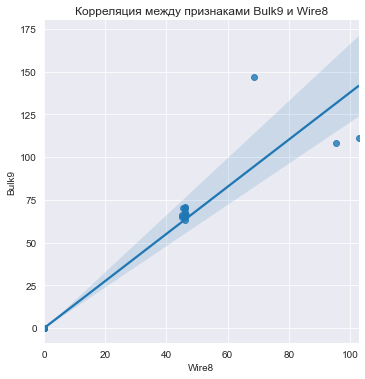

In [39]:
plt.figure(figsize=(20,10))
sns.lmplot(x='Wire8', y='Bulk9', data=full)
plt.title('Корреляция между признаками Bulk9 и Wire8')
plt.show()

In [40]:
full['Wire8'].describe()

count    2475.000000
mean        0.292947
std         4.271452
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       102.762401
Name: Wire8, dtype: float64

In [41]:
full['Bulk9'].describe()

count    2475.000000
mean        0.418586
std         6.035209
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       147.000000
Name: Bulk9, dtype: float64

**Вывод:** судя по вышеуказанному, рассчитанный индекс корреляции является случайным в данных по этим признакам было достаточно много пропущенных значений (более 99% процентов от всего датасета, т.к. именно эти материалы при производстве использовались реже всего), что могло вызвать аномалии при их заполнении.<br>
По остальным признакам ярковыраженной корреляции замечено не было, датасет готов для дальнейшей работы.

### 2.4 Разделение данных на выборки и масштабирование признаков

Разделим данные на обучающую и тестовую выборки в соотношении 70%/30%:

In [42]:
train, test = train_test_split(full, test_size = 0.3, random_state = 42)

In [43]:
print('Размер обучающей выборки: ', train.shape)
print('Размер обучающей выборки: ', test.shape)

Размер обучающей выборки:  (1732, 29)
Размер обучающей выборки:  (743, 29)


In [44]:
# train выборка
features_train = train.drop('last_temp', axis=1)
target_train = train['last_temp']


# test выборка
features_test = test.drop('last_temp', axis=1)
target_test = test['last_temp']

Произведём масштабирование признаков:

In [45]:
numeric = list(features_train.columns)
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Вывод:** данные разделены на выборки, произведено масштабирование признаков.

## 3. Обучение и тестирование моделей

Для заключительной части работы отберём следующие модели:
- LinearRegression
- CatBoostRegressor
- LGBMRegressor

Для каждой из них подберём оптимальные гиперпараметры и, для финальной проверки на тестовых данных отберём ту, которая покажет наилучшие результаты.

### 3.1 LinearRegression

In [46]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

In [47]:
model = LinearRegression()
model.fit(features_test, target_test)

predictions = model.predict(features_train)
print('Значение MAE линейной регрессии на обучающей выборке: ', mean_absolute_error(target_train, predictions))

Значение MAE линейной регрессии на обучающей выборке:  8.357221575338487


**Вывод:** значение метрики **MAE** при проверке модели линейной регрессии на тестовой выборке - **8.35**.<br>
Попробуем другие модели.

### 3.2 CatBoostRegressor

В цикле произведём подбор оптимальных гиперпараметров:

In [48]:
%%time
catboost_results = []

for n_estimators in [100, 200, 400]:
    for learning_rate in [0.1, 0.01, 0.001]:
        for depth in np.arange(2, 6):
            model = CatBoostRegressor(random_state=42, loss_function='MAE',
                                     n_estimators=n_estimators,
                                     learning_rate=learning_rate,
                                     depth=depth)
            model.fit(features_train, target_train, verbose=False)
            predictions = model.predict(features_train)
            catboost_results.append([model.get_params(), mean_absolute_error(target_train, predictions)])

Wall time: 16.1 s


In [49]:
catboost_results = pd.DataFrame(catboost_results, columns = ['params', 'mae_test'])
catboost_best_params = catboost_results.sort_values('mae_test', ascending=True).head(1)

In [50]:
print(list(catboost_best_params.params))
print('Значение MAE на обучающей выборке: ', catboost_best_params['mae_test'].values)

[{'learning_rate': 0.1, 'depth': 5, 'loss_function': 'MAE', 'n_estimators': 400, 'random_state': 42}]
Значение MAE на обучающей выборке:  [3.87799637]


**Вывод:** лучшее значение метрики MAE модели CatBoostRegressor - 3.87, используя следующие гиперпараметры: learning_rate: 0.1, depth: 5, loss_function: 'MAE', n_estimators: 400.

Попробуем ещё одну модель и сравним их результаты работы.

### 3.3 LGBMRegressor

Подберём оптимальные гиперпараметры:

In [51]:
%%time
lgbm_results = []

for boosting_type in ['gbdt', 'dart', 'goss']:
    for learning_rate in [0.1, 0.01, 0.001]:
        for max_depth in np.arange(2, 7):
            model = LGBMRegressor(random_state=42, metric='mae',
                                 boosting_type=boosting_type,
                                 learning_rate=learning_rate,
                                 max_depth=max_depth)
            
            model.fit(features_train, target_train, verbose=False)
            predictions = model.predict(features_train)
            lgbm_results.append([model.get_params(), mean_absolute_error(target_train, predictions)])

Wall time: 3.66 s


In [52]:
lgbm_results = pd.DataFrame(lgbm_results, columns = ['params', 'mae_test'])
lgbm_best_params = lgbm_results.sort_values('mae_test', ascending=True).head(1)

In [53]:
print(list(lgbm_best_params.params))
print('Значение MAE на обучающей выборке: ', lgbm_best_params['mae_test'].values)

[{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'mae'}]
Значение MAE на обучающей выборке:  [4.11134471]


**Вывод:** модель **LGBMRegressor** показала результаты чуть хуже, чем модель **CatBoostRegressor** - значение метрики **MAE** при проверке на обучающих данных равно **4.1**.

Для финального тестирования целесообразнее выбрать модель **CatBoostRegressor**, т.к. она показала наилучшие результаты.

## 4. Финальное тестирование

Для финального тестирования была отобрана модель **CatBoostRegressor**.<br>
Ранее мы сохранили в отдельную переменную значения гиперпараметров модели, показавшей наишучшие результаты.<br>
Протестируем данную модель на проверочных данных:

In [54]:
print(list(catboost_best_params.params))

[{'learning_rate': 0.1, 'depth': 5, 'loss_function': 'MAE', 'n_estimators': 400, 'random_state': 42}]


In [55]:
%%time
model = CatBoostRegressor(learning_rate=0.1, depth=5, loss_function='MAE', n_estimators=400, random_state=42)

model.fit(features_train, target_train, verbose=100)
predictions = model.predict(features_test)

print('Значение метрики MAE на проверочных данных: ', mean_absolute_error(target_test, predictions))

0:	learn: 9.8468812	total: 2.08ms	remaining: 829ms
100:	learn: 5.1452811	total: 212ms	remaining: 627ms
200:	learn: 4.4662843	total: 444ms	remaining: 440ms
300:	learn: 4.1149341	total: 646ms	remaining: 213ms
399:	learn: 3.8779954	total: 842ms	remaining: 0us
Значение метрики MAE на проверочных данных:  5.972189859958261
Wall time: 1.04 s


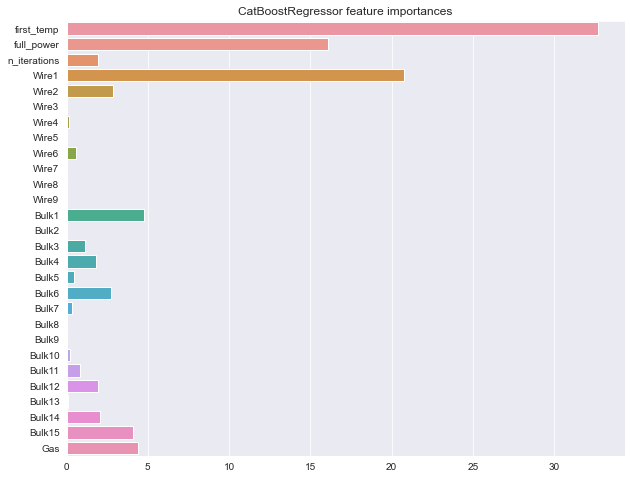

In [56]:
plt.figure(figsize=(10,8))
sns.barplot(model.feature_importances_, features_test.columns)
plt.title('CatBoostRegressor feature importances')
plt.show()

**Вывод:**
Модель **CatBoostRegressor** показывает приемлемые в рамках проекта значения метрики MAE - **5.97**.<br>
График позволяет сделать выводы о том, что в данных присутствует некоторое количество признаков, которые в наименьшей степени влияют на целевой признак.<br>По большей части, не особо значимыми признаками являются данные по сыпучим/проволочным материалам, по котормым в датасете изначально было большое количество пропущенных значений.<br>
В наибольшей степени на целевой признак влияет начальная температура, полная мощность и некоторые сыпучие/проволочные материалы (такие, например, как **Wire1** и **Bulk1**).

## Общий вывод

- Был проведён исследовательский анализ данных - обнаружили, что в датасете отсутствует часть данных по температуре и некоторые признаки, такие как активная и реактивная мощность сильно коррелируют между собой, из-за чего было принято решение на их основе вывести новый признак - полная мощность.
- Таблицы были объединены в одну по признаку ``key``, пропуски были обработаны
- В качестве возможных вариантов выбора модели были отобраны 3: Линейная регрессия, CatBoostRegressor и LGBMRegressor. Путём подбора гиперпараметров мы выяснили, что модель CatBoostRegressor показывает наилучшие результаты на обучающих данных и финальное тестирование было проведено с её использованием.
- Модель **CatBoostRegressor** показала приемлемые результаты работы при тестировании на проверочных данных - значение метрики MAE равно 5.97.
- Выяснили, какие из признаков наиболее сильно влияют на целевой признак.

## Отчёт по решению

В отчёте ответим на вопросы:
    
    
- Какие пункты плана были выполнены, а какие — нет (поясните почему)?
- Какие трудности возникли и как вы их преодолели?
- Какие ключевые шаги в решении задачи выделили?
- Какая ваша итоговая модель и какое у неё качество?

### Какие пункты плана были выполнены, а какие — нет (поясните почему)?

После проведения исследовательского анализа данных был намечен план на дальнейшую работу - вернёмся к нему и проанализируем, какие его пункты были выполнены, а какие нет.<br>
Нам требовалось:
- Провести предобработку данных: изменить тип данных в тех таблицах, в которых это требуется
- Обработать пропущенные значения
- Объединить таблицы в одну, которая будет содержать следующие признаки: количество итераций, первая и последняя температура, рассчитанная полная мощность, объём сыпучих и проволочных материалов, данные о продувке сплава газом.
- Последнее измерение температуры будет являться целевым признаком.
- Провести обучение нескольких моделей, подобрать оптимальные гиперпараметры и отобрать из моделей ту, которая покажет наилучшие результаты.

Что было выполнено в итоге:
- Была проведена предобработка данных:
    - Рассчитали новый признак в таблице **data_arc** - ``полная мощность``, т.к. была замечена достаточно сильная корреляция между признаками активной и реактивной мощности и требовалось на их основе вывести новый, избавившись от них.
    - Все таблицы были объединены в одну, чему способствовал тот факт, что все они имели общий столбец с номером партии.
    - Были обработаны пропуски, присутствующие в таблицах изначально и те, которые возникли в результате объединения таблиц.
    - В результате предобработки данных, мы получили финальную таблицу, содержащую следующие признаки: первая измерянная температура, последняя измерянная температура (целевой признак), полная мощность, количество итераций обработки в партии, данные о продувке газом и объём различных сыпучих/проволочных материалов по партиям.
    
Все пункты плана, которые касались предобработки данных были выполнены.

Последний пункт плана - обучение моделей.<br>
Что было выполнено по данному пункту:
- Для тестирования были выбраны следующие модели:
    - Модель линейной регрессии, которая, показав достаточно плохие результаты со значением метрики MAE на тренировочных данных, равной **8.35**, позволила отметить границу значения точности, на которую можно было бы ориентироваться, при тестировании остальных моделей.
    - Модель LGBMRegressor.
    - Модель CatBoostRegressor
- В результате проверки на обучающих данных, лучший показатель метрики MAE показала модель **CatBoostRegressor**, которая и была отобрана для финального тестирования.

### Какие трудности возникли и как вы их преодолели?

Возникли некоторые технические затруднения с тем, что проект выполнялся локально и, в последствии, загружался и проверялся в облачном тренажёре - отличались версии некоторых библиотек.<br>
После синхронизации версий и доработки кода проблема себя исчерпала.

### Какие ключевые шаги в решении задачи выделили?

Одним из ключевых шагов в решении данной задачи было определение, какой именно признак использовать в качестве целевого при обучении моделей и, самым логичным, было выбрать именно конечную температуру в партии, т.к. практически все остальные признаки в значимой мере влияют на неё (обработка сырья газом, добавление различных материалов и количество итераций - всё это оказывает влияние на температуру сплава).

Также важным шагом был отказ от некоторых таблиц с данным, которые содержали только лишь временную метку добавления того или иного материала в различных итерациях обработки, т.к. они лишь бы усложнили работу модели, да и финальные данные нужно было сгруппировать по партиям, что в любом случае бы обобщило данные по различным итерациям в каждой партии.

### Какая ваша итоговая модель и какое у неё качество?

В качестве итоговой модели была отобрана **CatBoostRegressor**, т.к. она показала достаточно хороший (по сравнению с остальными тестируемыми моделям) показатель метрики **MAE**.

Финальное тестирование с подобранными ранее оптимальными гиперпараметрами позволило получить приемлемое значение метрики MAE в рамках проекта, равное **5.97**.

Также была проведена проверка важности отдельных признаков в данных, что позволило бы, в дальнейшем, сделать корректировки при обучении моделей и, вполне возможно, помогло бы технологам производства сделать выводы о важности тех или иных легирующих добавок.